In [1]:
import pydicom as dicom;
from skimage import io,measure, exposure, img_as_float, img_as_ubyte;
from scipy import ndimage;
from skimage.restoration import estimate_sigma, denoise_nl_means;
from skimage.filters import roberts, sobel, prewitt, scharr, threshold_multiotsu;
from matplotlib import pyplot as plt;
import numpy as np;
from skimage.segmentation import random_walker;
import cv2;

ds = dicom.dcmread('ANTERIOR001_DS.dcm');
pixelArea = ds.PixelSpacing[0] * ds.PixelSpacing[1];
rows = ds.Rows;
cols = ds.Columns;
patientId = ds.PatientID;
pixelArray = ds.pixel_array.clip(0, 100);
pixelArray = img_as_float(pixelArray / pixelArray.max());

In [5]:
plt.imsave('./piexlArray.png', pixelArray, cmap='gray');

In [2]:
denoised = ndimage.median_filter(pixelArray, size=3);
plt.imsave('./denoised.png', denoised, cmap='gray');

#sigma_est = np.mean(estimate_sigma(pixelArray, multichannel=False))
#patch_kw = dict(patch_size=5,patch_distance=6,multichannel=False)

# denoised = denoise_nl_means(pixelArray, h=1.15 * sigma_est, fast_mode=False,**patch_kw)

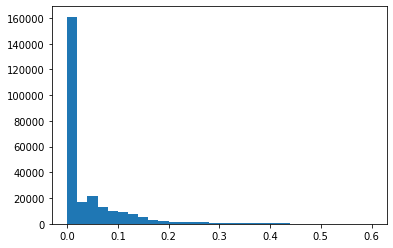

In [22]:
plt.hist(denoised.flat, bins=30, range=(0, 0.6));

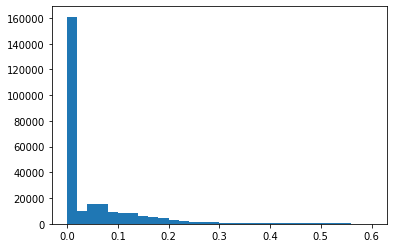

In [3]:
eq = exposure.equalize_adapthist(denoised);
plt.hist(eq.flat, bins=30, range=(0, 0.6));

In [4]:
plt.imsave('./equalized.png', eq, cmap='gray');

[0.10351562 0.43164062]


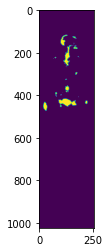

In [25]:
thresholds = threshold_multiotsu(eq, 3);
print(thresholds);
regions = np.digitize(eq, bins=thresholds);
bone = (regions == 1);
met = (regions == 2);
#plt.imshow(met);
#plt.imshow(bone);

segmented = np.zeros(eq.shape, dtype=np.float);
segmented[met] = eq[met];
plt.imshow(met);

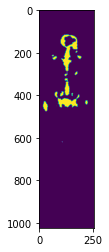

In [6]:
markers = np.zeros(eq.shape, dtype=np.uint);
markers[(eq < 0.1)] = 1;
markers[(eq > 0.1) & (eq < 0.25)] = 2;
markers[(eq >= 0.3)] = 3;

labels = random_walker(eq, markers, beta=10, mode='bf');
bone = (labels == 2);
met = (labels == 3);
#plt.imshow(met);
#plt.imshow(bone);

segmented = np.zeros(eq.shape, dtype=np.float);
segmented[met] = eq[met];
plt.imshow(met);

In [10]:
from skimage.color import label2rgb;
imgLabeled = measure.label(edge_sobel > 0, connectivity=eq.ndim);
#imageLabelOverlay = label2rgb(imgLabeled, image=eq);
# plt.imshow(imageLabelOverlay);
# cv2.imshow('labeld', imageLabelOverlay);
# cv2.waitKey(0);
# cv2.destroyAllWindows();

props = measure.regionprops_table(imgLabeled, eq, properties=['area', 'label', 'centroid']);

import pandas as pd;
data = pd.DataFrame(props);
print(data);

    area  label  centroid-0  centroid-1
0    796      1  141.951005  112.232412
1    152      2  128.236842  164.677632
2     19      3  155.421053  162.105263
3   1688      4  215.735190  132.235190
4    248      5  175.241935  169.052419
5     27      6  218.037037  182.407407
6     51      7  222.882353   76.019608
7      8      8  223.000000  186.000000
8     12      9  227.500000   68.000000
9     25     10  265.240000  126.680000
10   114     11  297.008772  172.885965
11    47     12  325.276596  125.723404
12   498     13  369.991968  130.682731
13   155     14  394.329032   79.367742
14     8     15  386.000000  110.000000
15    38     16  397.368421  102.157895
16    15     17  407.000000  183.000000
17  2173     18  434.018408  129.692131
18   187     19  432.823529  220.053476
19   638     20  451.993730   28.501567


In [26]:
edge_roberts = roberts(segmented);
edge_sobel = sobel(segmented);
edge_scharr = scharr(segmented);
edge_prewitt = prewitt(segmented);
#cv2.imshow('roberts', edge_roberts);
#cv2.imshow('sobel', edge_sobel);
cv2.imshow('sobel', edge_sobel);
#cv2.imshow('scharr', edge_scharr);
#cv2.imshow('prewitt', edge_prewitt);
cv2.waitKey(0);
cv2.destroyAllWindows();
plt.imsave('./sobel.png',edge_sobel, cmap='gray');

In [27]:
edged = cv2.imread('./sobel.png', 0);
plt.imsave('./eq.png', eq, cmap='gray');
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_NONE);
colored = cv2.cvtColor(cv2.imread('./eq.png', 0), cv2.COLOR_GRAY2BGR)
cv2.drawContours(colored, contours, -1, (0,255,0), 1);
cv2.imshow('contours', colored);
cv2.waitKey(0);
cnts = sorted(contours, key=cv2.contourArea, reverse=True)
areas = []
for cnt in cnts:
    areas.append(cv2.contourArea(cnt));
print(areas);
cv2.destroyAllWindows();

[2050.0, 1550.0, 722.5, 590.5, 453.5, 215.0, 164.0, 127.5, 125.5, 95.5, 39.5, 34.5, 27.0, 18.0, 14.0, 11.5, 8.0, 6.0, 4.0, 4.0]


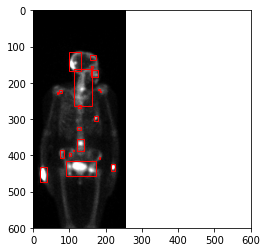

[2173, 1688, 796, 638, 498, 248, 187, 155, 152, 114, 51, 47, 38, 27, 25, 19, 15, 12, 8, 8]


In [14]:
import math;
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.imshow(eq, cmap=plt.cm.gray)

imgLabeled = measure.label(edge_sobel > 0, connectivity=eq.ndim);
regionsProps = measure.regionprops(imgLabeled)
count = 0
areas = []
for props in regionsProps:
    if props.area >= 1:
        areas.append(props.area);
        minr, minc, maxr, maxc = props.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        count += 1;
ax.axis((0, 600, 600, 0))
plt.show()
areas = sorted(areas, reverse=True);
print(areas);

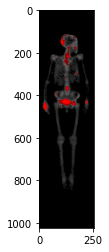

In [28]:
false_colors = np.zeros((rows, cols, 3), dtype=np.uint8);
for i in range(rows):
    for j in range(cols):
        if met[i,j]:
            false_colors[i,j] = (eq[i,j] * 255, 0, 0);
        if bone[i,j]:
            intensity = eq[i,j] * 255;
            false_colors[i,j] = (intensity, intensity, intensity);
plt.imshow(false_colors);

In [29]:
cv2.imshow('denoised and equalized', eq);
cv2.imshow('segmented', segmented);
cv2.imshow('false colors', cv2.cvtColor(false_colors, cv2.COLOR_RGB2BGR)); 
cv2.imshow('org', pixelArray);
cv2.waitKey(0);
cv2.destroyAllWindows();